In [2]:
import numpy as np
import climlab
from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation
import matplotlib.pyplot as plt

#we want to calculate a difference vector 

#timesteping 
t_i = 0
t_f = -700000 #run model for 700,000 years 
d_t = 100 #use time step of 100 years
t = np.arange(t_f, t_i+1, 500)
t_kyr = (t/(1000)) # years in kyr

#grid spacing
x_i = 30 #30 degrees North latitude (southern boundary)
x_f = 74 #74 degrees North latitude (northern boundary)
d_x = 0.5 #0.5 degrees as spacial step equivalent to 55km
x = np.arange(x_i, x_f+.5, d_x)

days = np.linspace(1.,50.)/50 * 365.24
orb = OrbitalTable.interp(kyear=t_kyr )

Q = daily_insolation(x, days, orb) #calculate daily insolation per every 500 years based on orbit parameters


Tokenization took: 1.91 ms
Type conversion took: 1.31 ms
Parser memory cleanup took: 0.00 ms


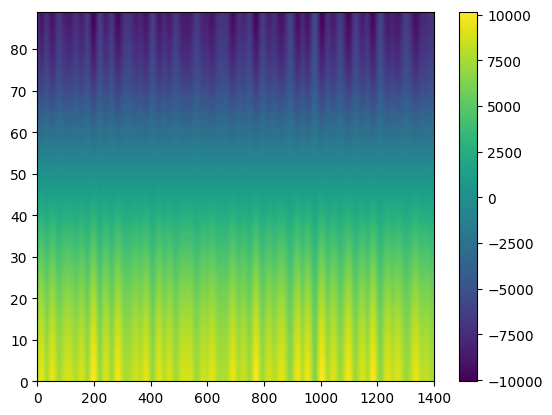

In [3]:
#to calculate summer half year insolation, we first need to find the upper half of the daily insolations
# we do this by splitting the data by the along median

delta_Q = np.zeros((len(x), len(t_kyr)))

for i in range(len(t_kyr)):
    daily_55 = Q[50, :, i]
    median_insolation_55 = np.median(daily_55)
    p_55 = np.zeros((50,2))
    p_55[:,0] = days
    p_55[:,1] = daily_55
    summer_55 = p_55[p_55[:, 1] >= median_insolation_55]
    area_55 = np.trapz(summer_55[:,1], summer_55[:, 0])
    for j in range(len(x)):
        daily = Q[j,:, i]
        median_insolation = np.median(daily)
        p = np.zeros((50,2))
        p[:,0] = days
        p[:,1] = daily
        summer = p[p[:, 1] >= median_insolation]
        area = np.trapz(summer[:,1], summer[:, 0])
        #now need to subtract the 55 degree N summer half year from each latitute to find delta Q
        delta_Q[j, i] = area-area_55



plt.figure()
plt.pcolor(delta_Q)
plt.colorbar()


(89, 1401)


In [ ]:
# now we need to calculate E0 the present equilibrium line
def E0(x):
    return (9e-4 * x) - (6.57e-2)

#now we can combine E0 and delta_Q
k = 25 #insolation sensitivity, meter light-years^-1 day
def E(x, t):
    return E0(x) + k * delta_Q[x,t] #might have to change indexing later

#Finally we define G, the nonlinear term of the diffusion equation 
a = 0.81e-3 #years^-1
b = 0.3e-6 #meters^-3 years^-1
def G(x, t, h):
    if (h - E(x,t) <= 1500):
        return a*(h-E) - b*(h-E)**2
    else:
        return 0.56
